# Example for the teleconnections

In [3]:
import yaml
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# teleconnection config details

diagname  = 'teleconnections'
machine   = 'wilma'
telecname = 'NAO'

# Opening yml files

with open(f'../../config/config_{machine}.yml', 'r', encoding='utf-8') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

with open(f'{diagname}.yml', 'r', encoding='utf-8') as file:
    namelist = yaml.load(file, Loader=yaml.FullLoader)

# Opening dataset file

infile = config[diagname][telecname]['input']

field = xr.open_mfdataset(infile)['msl'] # single quantity name to be standardize

## Evaluate monthly msl anomalies

In [5]:
# monthly msl average
field_av = field.groupby("time.month").mean(dim="time")

# monthly msl anomalies
field_an = field.groupby("time.month") - field_av

field_av

/work/users/mnurisso/mambaforge/envs/aqua/lib/python3.11/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


<xarray.DataArray 'msl' (month: 12, lat: 721, lon: 1440)>
dask.array<stack, shape=(12, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Mean sea level pressure
    units:          Pa
    code:           151
    table:          128
    institution:    ECMWF

This way to evaluate anomalies has some known problem with Dask and can be quite slow.

[Suggested workaround](https://gist.github.com/rabernat/30e7b747f0e3583b5b776e4093266114) (to be checked and implemented)

## Check and adapt coordinates

In [87]:
def lon_180_to_360 (lon):
    """ 
    Convert longitude [-180,180] to [0,360] range.

    Parameters
    ----------
    lon : float

    Returns
    -------
    float
    """
    if (lon<0):
        #lon = (lon+180) % 360
        lon = 360 + lon
    return lon

def lon_360_to_180 (lon):
    """ 
    Convert longitude [0,360] to [-180,180] range.

    Parameters
    ----------
    lon : float

    Returns
    -------
    float
    """
    if (lon>180):
        #lon = (lon+180) % 360
        lon = - 360 + lon
    return lon

In [89]:
# Azores
lon1 = lon_180_to_360(namelist[telecname]['lon1'])
lat1 = namelist[telecname]['lat1']

# Reykiavik
lon2 = lon_180_to_360(namelist[telecname]['lon2'])
lat2 = namelist[telecname]['lat2']

print('Azores',lat1,lon1)
print('Ryekjavik',lat2,lon2)

Azores 37.7 334.3
Ryekjavik 64.1 338


"\nccrs.PlateCarree()\n\nplt.figure(figsize=(8,4))\nax = plt.axes(projection=ccrs.PlateCarree())\nax.set_xlabel('longitude')\nax.set_ylabel('latitude')\nax.coastlines()\nax.plot(lon_list,lat_list,'or')\n\nfield_av[0].plot(ax=ax)\n"

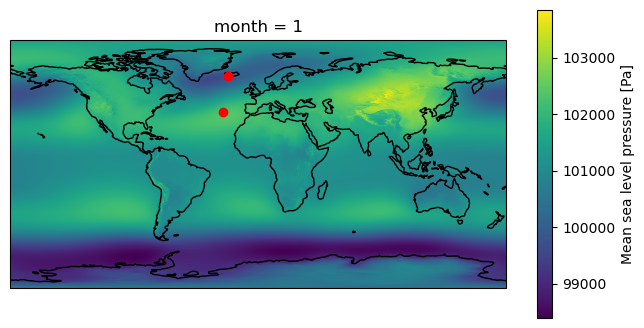

In [90]:
import cartopy.crs as ccrs

########
# Plot #
########

lon_list = [lon_360_to_180(lon1),lon_360_to_180(lon2)]
lat_list = [lat1,lat2]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax = fig.add_subplot(1,1,1)
ax.set_global()
ax.coastlines()

field_av[0].plot(ax=ax)
ax.plot(lon_list,lat_list,'or')
#ax.set_xticks(ax.get_xticks())
#ax.set_yticks(ax.get_yticks())
#plt.xlabel('test2')
'''
ccrs.PlateCarree()

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.coastlines()
ax.plot(lon_list,lat_list,'or')

field_av[0].plot(ax=ax)
'''

## NAO evaluation, no temporal rolling average

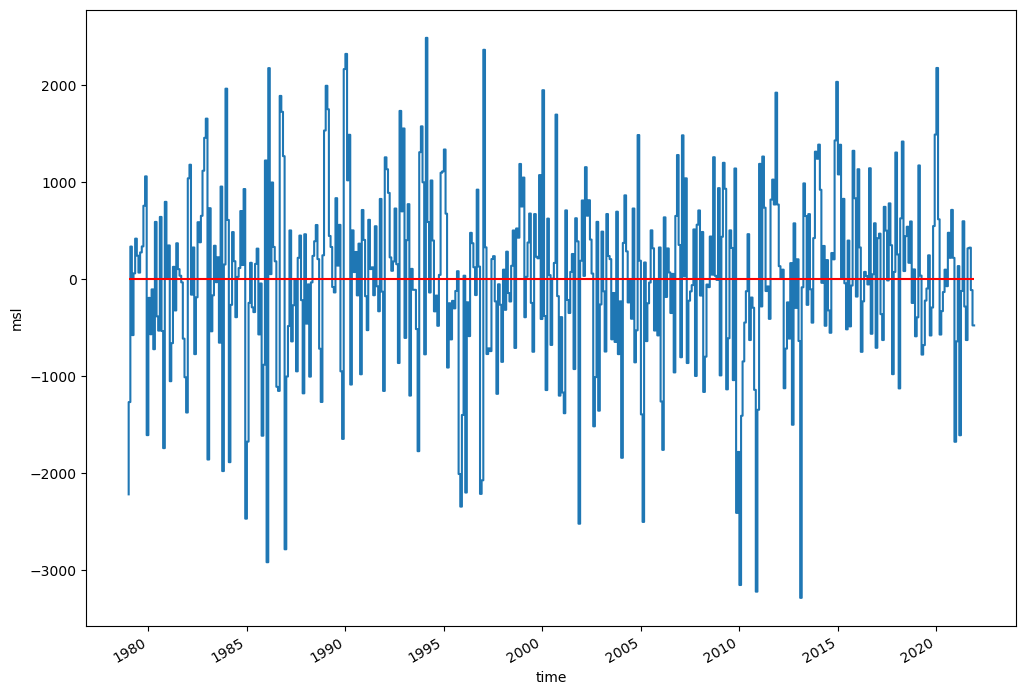

In [91]:
#prs1 = field.sel(lon=namelist[telecname]['lon1'],lat=namelist['NAO']['lat1'],method="nearest")
#prs2 = field.sel(lon=namelist[telecname]['lon2'],lat=namelist['NAO']['lat2'],method="nearest")

# Evaluating NAO

msl1 = field_an.sel(lon=lon1,lat=lat1,method='nearest')
msl2 = field_an.sel(lon=lon2,lat=lat2,method='nearest')

NAO = msl1-msl2

########
# Plot #
########

fig, ax = plt.subplots(figsize=(12, 8))

NAO.plot(ax=ax,ds='steps')
ax.hlines(y=0,xmin=min(NAO['time']),xmax=max(NAO['time']),color='red')

## Seasonal (3-months) average

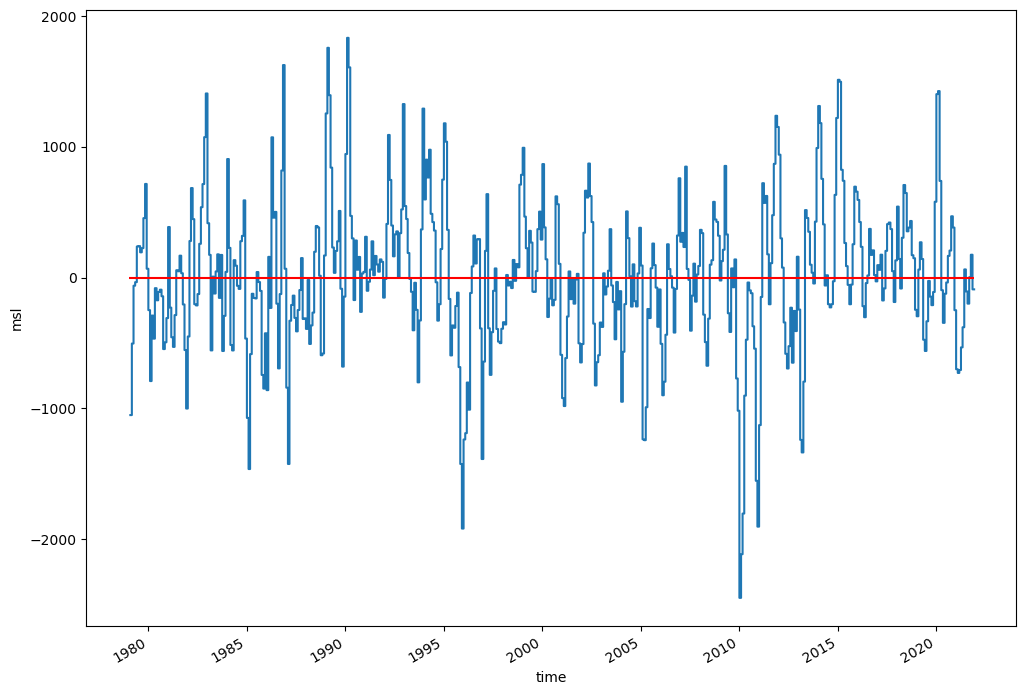

In [92]:
msl1_ma = msl1.rolling(time=3).mean() # to be generalized to data not gridded monthly
msl2_ma = msl2.rolling(time=3).mean()

NAO_ma = msl1_ma-msl2_ma

########
# Plot #
########

fig, ax = plt.subplots(figsize=(12, 8))

NAO_ma.plot(ax=ax,ds='steps')
ax.hlines(y=0,xmin=min(NAO_ma['time']),xmax=max(NAO_ma['time']),color='red')

## Index evaluation (3 months average)

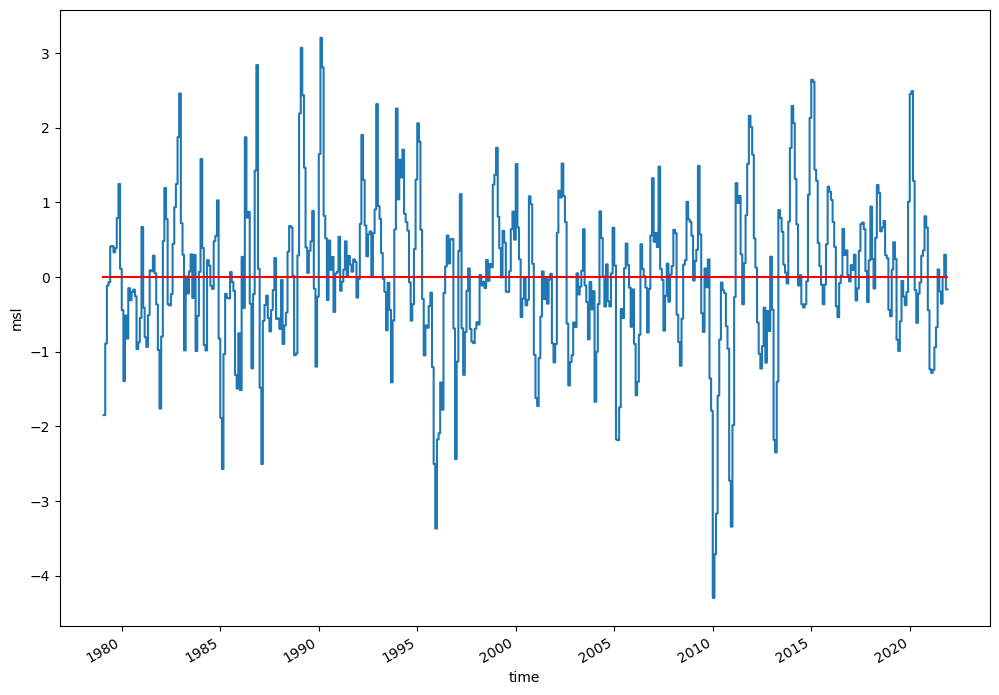

In [93]:
mean_ma = NAO_ma.mean()
std_ma  = NAO_ma.std()

NAO_ma_std = (NAO_ma-mean_ma)/std_ma

########
# Plot #
########

fig, ax = plt.subplots(figsize=(12, 8))

NAO_ma_std.plot(ax=ax,ds='steps')
ax.hlines(y=0,xmin=min(NAO_ma_std['time']),xmax=max(NAO_ma_std['time']),color='red')


## Different time selection

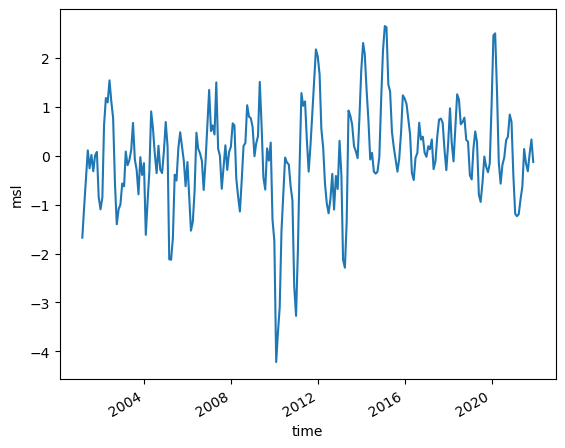

In [94]:
msl1_tsel = msl1.sel(time=msl1.time.dt.year>2000)
msl2_tsel = msl2.sel(time=msl2.time.dt.year>2000)

msl1_tsel = msl1_tsel.rolling(time=3).mean()
msl2_tsel = msl2_tsel.rolling(time=3).mean()

NAO_tsel = msl1_tsel-msl2_tsel

NAO_tsel_mean = NAO_tsel.mean()
NAO_tsel_std  = NAO_tsel.std()

indx_tsel = (NAO_tsel-NAO_tsel_mean)/NAO_tsel_std
indx_tsel.plot()

## Save output to .nc database

In [96]:
outfile = config[diagname]['output']
filename = '/NAO_indx.nc'
outfile = outfile+filename

NAO_ma_std.to_netcdf(outfile)

**Possible problem:** if the file already exists in the proposed path `to_netcdf` gives an error:

`Permission denied: b'/scratch/users/mnurisso/aqua/teleconnections/NAO_indx.nc'`